# 2D projection parameters testing

Use this notebook to:

1. separately test each step used in the 3D to 2D projection of an image stack, and visualize the result after each step. 

2. explore the effect of the proejction parameters and find the best values for the current dataset.

In [1]:
# import packages 
from skimage import io
import numpy as np
import matplotlib.pyplot as plt
import sys
import os

%matplotlib notebook

root_dir = os.path.join(os.getcwd(), '..')
sys.path.append(root_dir)

from src.projection import fit_spline_onto_convex_profile

In [11]:
# Parameters for spline fitting:
params = {'min_y':5, 'meridian_plane_x':62,'spline_smoothing':5, 'projection_radius':5}

# Load a test image:
C1_filename = "../test_dataset/03_registered/Registered_C1-Image1.tif"
C2_filename = "../test_dataset/03_registered/Registered_C2-Image1.tif"
mask_file = "../test_dataset/References_and_masks/Reference_mask_iso_thick.tiff"
reference_shape_file = "../test_dataset/References_and_masks/Reference_mask_iso.tiff"

image_c1 = io.imread(C1_filename)
image_c2 = io.imread(C2_filename)
image_mask = io.imread(mask_file)
ref_shape = io.imread(reference_shape_file)

image_c1 = image_c1*image_mask
image_c2 = image_c2*image_mask

### Test spline fitting of image slice

<IPython.core.display.Javascript object>


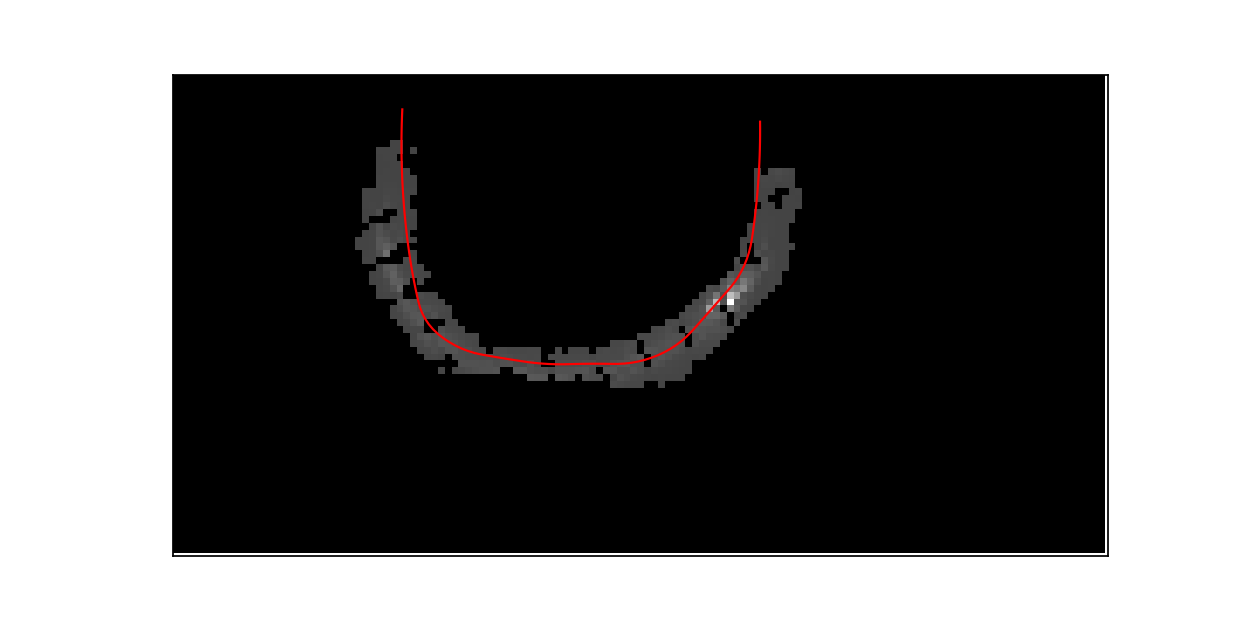

In [13]:
# select a slice from the image stack:
layer = 80
img_slice = (image_c1)[:,:,layer]
ref_mask_slice = image_mask[:,:,layer]
x, y = fit_spline_onto_convex_profile(img_slice, ref_mask_slice, 
                                              y_min_cutoff = params['min_y'], 
                                              smoothing_n = params['spline_smoothing'])

fig, ax = plt.subplots(figsize=(8, 4))
ax.imshow(img_slice, cmap=plt.cm.gray)
ax.plot(x, y, "-r", lw=1)
ax.set_xticks([]), ax.set_yticks([])
ax.axis([0, img_slice.shape[1], img_slice.shape[0], 0])

plt.show()

## Test spline projection

The spline projection transforms the 3D image stack (x,y,z where x is axis on which the stack is sliced), into a 2D image in x-d coordinates, where d is the distance along the spline. 
At each position along the spline, the brightness is calculated as the maximum along the local perpendicular direction to the curve, within a maximum distance from the curve.

<IPython.core.display.Javascript object>


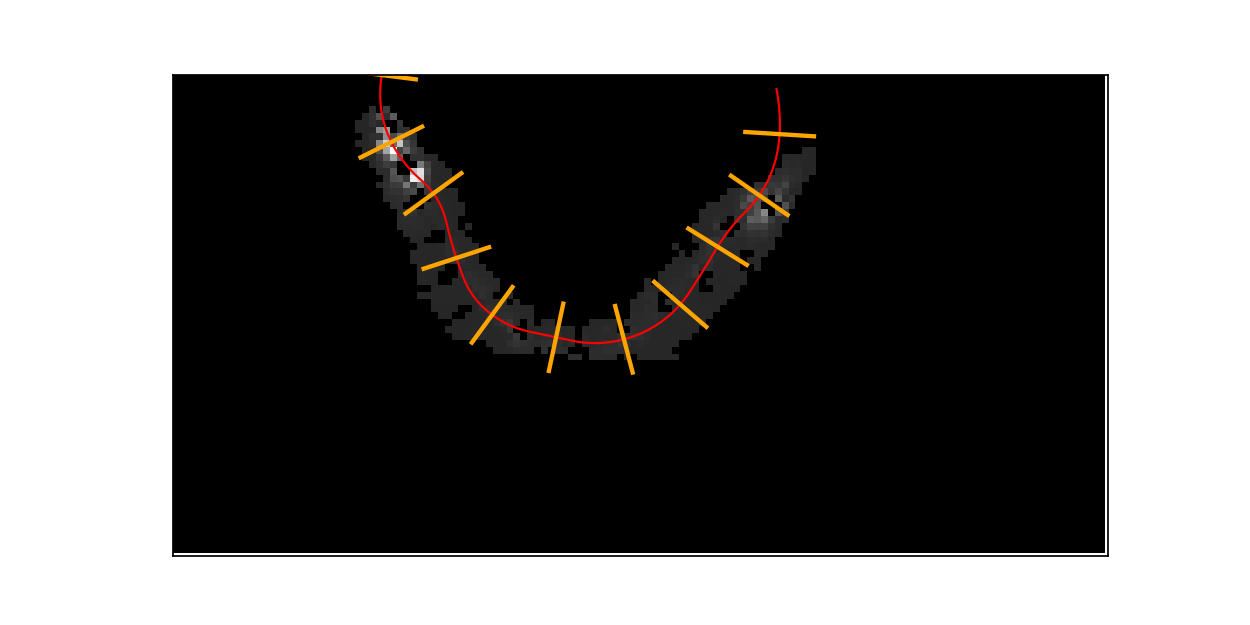

In [8]:
### Visualize the local perpendicular direction to the curve:

diff_x_fw = x[1:]-x[:-1]
diff_y_fw = y[1:]-y[:-1]
diff_x = np.concatenate([[0], diff_x_fw])+np.concatenate([diff_x_fw,[0]])
diff_y = np.concatenate([[0], diff_y_fw])+np.concatenate([diff_y_fw,[0]])
diff_x[1:-1] = diff_x[1:-1]/2 
diff_y[1:-1] = diff_y[1:-1]/2 

fig, ax = plt.subplots(figsize=(8, 4))
ax.imshow(img_slice, cmap=plt.cm.gray)
ax.plot(x, y, "-r", lw=1)

radius = params['projection_radius']
for i in range(len(x)):
        
    norm = (diff_x[i]**2+diff_y[i]**2)**0.5
    perp_dx = -diff_y[i]/norm
    perp_dy = diff_x[i]/norm
    line_x = [x[i]-perp_dx*radius, x[i]+perp_dx*radius]
    line_y = [y[i]-perp_dy*radius, y[i]+perp_dy*radius]
    if i%10 == 0:
        ax.plot(line_x, line_y, "-", lw = 2, color = "orange")

ax.set_xticks([]), ax.set_yticks([])
ax.axis([0, img_slice.shape[1], img_slice.shape[0], 0])

plt.show()

<IPython.core.display.Javascript object>


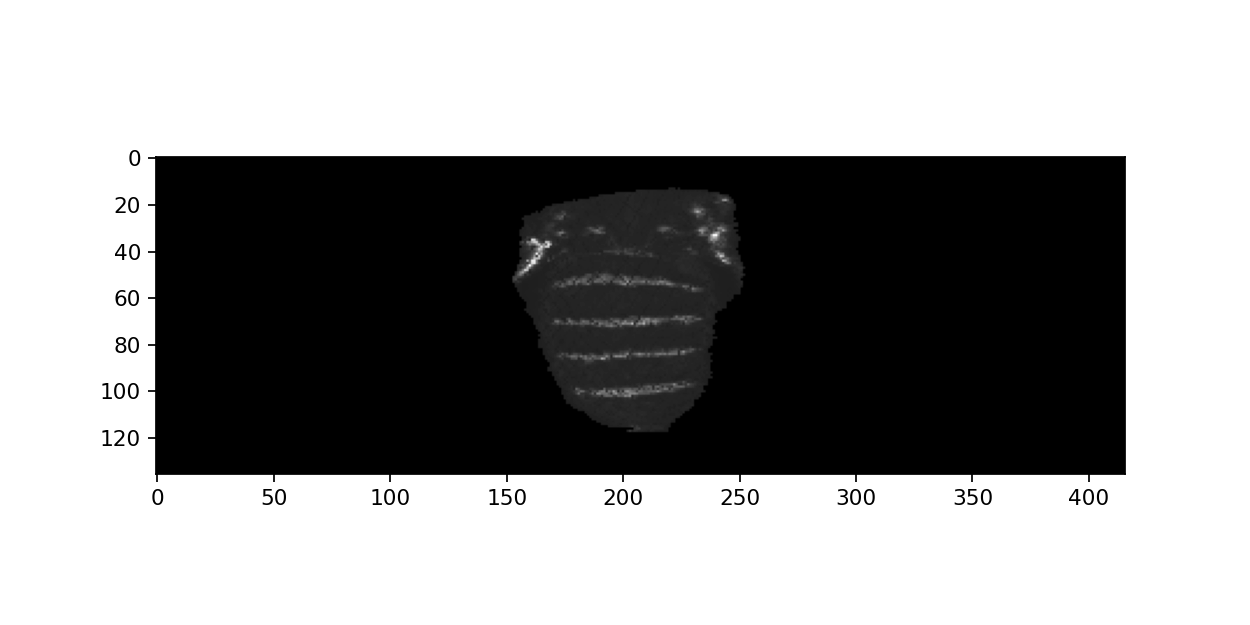

<IPython.core.display.Javascript object>


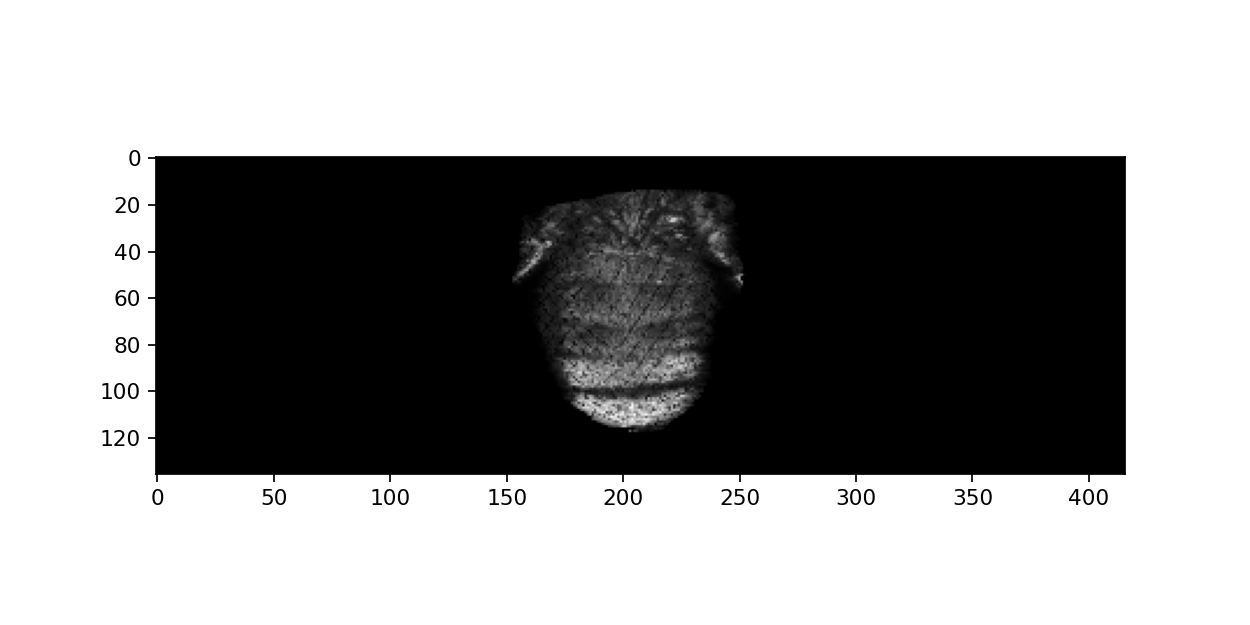

In [18]:
from src.projection import spline_sinusoid_projection_concave_surface

c1_filename = "../test_dataset/03_registered/Registered_C1-Image1.tif"
c2_filename = "../test_dataset/03_registered/Registered_C2-Image1.tif"
mask_file = "../test_dataset/References_and_masks/Reference_mask_iso_thick.tiff"
reference_shape_file = "../test_dataset/References_and_masks/Reference_mask_iso.tiff"

image_c1 = io.imread(C1_filename)
image_c2 = io.imread(C2_filename)
image_mask = io.imread(mask_file)
ref_shape = io.imread(reference_shape_file)

image_c1 = image_c1*image_mask
image_c2 = image_c2*image_mask

projected_c1 = spline_sinusoid_projection_concave_surface(image_c1, image_c1, ref_shape, **params)
projected_c2 = spline_sinusoid_projection_concave_surface(image_c1, image_c2, ref_shape, **params)

fig, ax = plt.subplots(figsize=(8, 4))
ax.imshow(projected_c1, cmap=plt.cm.gray)
plt.show()

fig, ax = plt.subplots(figsize=(8, 4))
ax.imshow(projected_c2, cmap=plt.cm.gray)
plt.show()